In [22]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import os
import matplotlib.pyplot as plt
import numpy as np

In [43]:
LEARNING_RATE = 0.001
BATCH_SIZE = 4096
N_EPOCHS = 7
dataDirectory = 'dataSet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ", device)

Device =  cuda


In [4]:
if not os.path.exists(dataDirectory):
    os.makedirs(dataDirectory)

downLoad = False
if not os.path.exists(os.path.join(dataDirectory, 'MNIST')):
    downLoad = True
trainData = datasets.MNIST(
    root = dataDirectory,
    train = True,
    transform = ToTensor(),
    download=downLoad
)
testData = datasets.MNIST(
    root = dataDirectory,
    train = False,
    transform = ToTensor(),
    download=downLoad
)

In [5]:
print("train data : ", trainData.data.shape)
print("test data : ", testData.data.shape)

train data :  torch.Size([60000, 28, 28])
test data :  torch.Size([10000, 28, 28])


In [6]:
loaders = {
    'trainLoader' : DataLoader(
        dataset=trainData, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=1
    )
    ,
    'testLoader' : DataLoader(
        dataset=testData, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=1
    )
}
loaders

{'trainLoader': <torch.utils.data.dataloader.DataLoader at 0x29ba5f044f0>,
 'testLoader': <torch.utils.data.dataloader.DataLoader at 0x29bd7c9c4c0>}

In [7]:
def train(
        model : nn.Module,
        optimizer : opt.Adam,
        lossFunction : nn.CrossEntropyLoss
):
        model.train()
        for idx, (data, target) in enumerate(loaders['trainLoader']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = lossFunction(output, target)
            loss.backward()
            optimizer.step()


@torch.no_grad()
def test(
        model : nn.Module,
        lossFunction : nn.CrossEntropyLoss
):
    model.eval()
    testLoss = 0
    correct = 0
    for data, target in loaders['testLoader']:
        data, target = data.to(device), target.to(device)
        output = model(data)
        testLoss += lossFunction(output, target).item()
        pred = output.argmax(dim = 1, keepdim = True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    testLoss /= len(loaders['testLoader'].dataset)
    print("Accuracy : ", 100*correct / len(loaders['testLoader'].dataset))

In [46]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        # self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300, 50)
        # self.bn2 = nn.BatchNorm1d(50)
        self.fc3 = nn.Linear(50, 10)
        # self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


In [47]:
mlp = MLP().to(device=device)
optimizer = opt.Adam(mlp.parameters(), lr=LEARNING_RATE)
lossFunction = nn.CrossEntropyLoss()

In [48]:
for _ in range(N_EPOCHS):
    train(
        model=mlp,
        optimizer=optimizer,
        lossFunction=lossFunction
    )
test(
    model=mlp,
    lossFunction=lossFunction
)   
    

Accuracy :  91.8


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(400, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool1(F.sigmoid(self.bn1(self.conv1(x))))
        x = self.pool2(F.sigmoid(self.bn2(self.conv2(x))))
        x = x.view(-1, 400)
        x = self.dropout(F.sigmoid(self.bn3(self.fc1(x))))
        x = self.dropout(F.sigmoid(self.bn4(self.fc2(x))))
        x = self.fc3(x)
        return x

In [11]:
cnn = CNN().to(device=device)
optimizer2 = opt.Adam(cnn.parameters(), lr=0.001)
lossFunction2 = nn.CrossEntropyLoss()

In [12]:
for _ in range(N_EPOCHS):
    train(
        model=cnn,
        optimizer=optimizer2,
        lossFunction=lossFunction2
    )
    test(
        model=cnn,
        lossFunction=lossFunction2
    )

Accuracy :  10.32
Accuracy :  65.56
Accuracy :  72.19
Accuracy :  51.4
Accuracy :  83.75
Accuracy :  87.8
Accuracy :  83.12
Accuracy :  86.19
Accuracy :  92.4
Accuracy :  94.6
Accuracy :  96.14
Accuracy :  96.28
Accuracy :  96.35
Accuracy :  96.72
Accuracy :  96.81


In [28]:
def shift_image(image, shiftBy = 2):
    image = image.numpy().squeeze()
    shifted_image = np.zeros_like(image)
    if shiftBy > 0:
        shifted_image[:, shiftBy:] = image[:, :-shiftBy]
    else:
        shifted_image[:, :shiftBy] = image[:, -shiftBy:]
    return torch.Tensor(shifted_image).unsqueeze(0)        

In [20]:
dataIterator = iter(loaders['testLoader'])
images, labels = dataIterator._next_data()

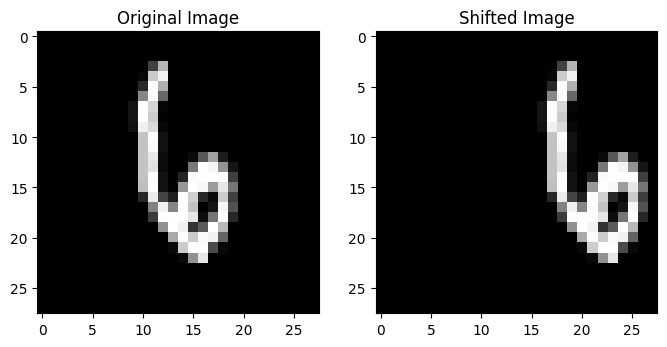

In [54]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[2].numpy().squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(shift_image(images[2], 7).squeeze(), cmap='gray')
plt.title('Shifted Image')
plt.show()

In [55]:
cnnOutput = cnn(images[2].unsqueeze(0).to(device))
_, cnn_pred = torch.max(cnnOutput, 1)
print("Prediction of CNN : ", cnn_pred.item())

Prediction of CNN :  6


In [57]:
mlpOutput = mlp(images[2].unsqueeze(0).to(device))
_, mlp_pred = torch.max(mlpOutput, 1)
print("Prediction of MLP : ", mlp_pred.item())

Prediction of MLP :  4
